In [1]:
%gui tk
import ipywidgets as widgets
from tkinter import filedialog
from tkinter import *

root = Tk()
i_file_name =  filedialog.askopenfilename(filetypes =[("tiff stack","*.tiff")])

input_path = widgets.Text(
    value = i_file_name,
    placeholder='Type something',
    description='tiff stack:',
    disabled=False
)

o_file_name = filedialog.asksaveasfilename(title = "Select file",filetypes = [("csv file","*.csv")])

output_path = widgets.Text(
    value = o_file_name,
    placeholder='Type something',
    description='save csv:'
)

root.withdraw()


display(input_path)
display(output_path)

Text(value='C:/Users/inst/Documents/GitHub/image_segmentation/data/2019-04-02 - Issa - Fe3Si -S3 (unlabelled, …

Text(value='C:/Users/inst/Documents/GitHub/image_segmentation/data/test', description='File path:', placeholde…

In [2]:

fac_1 = widgets.FloatText(
    description='fac 1'
)

fac_2 = widgets.FloatText(
    description='fac 2'
)

fac_3 = widgets.FloatText(
    description='fac 3'
)

fac_4 = widgets.FloatText(
    description='fac 4'
)

ui = widgets.HBox([fac_1, fac_2,fac_3,fac_4])

display(ui)


In [3]:
%matplotlib inline
import ipyvolume as ipv
import matplotlib.pyplot as plt
from skimage import data, io, filters
import numpy as np

from skimage import data, io, filters
## C:\Users\inst\SynologyDrive\Master\Exp\Hi-am\data\2019-04-10 - Issa - Fe3Si -S08 (unlabelled, green)_2um scan_recon.tiff
stack = io.imread(input_path.value).T


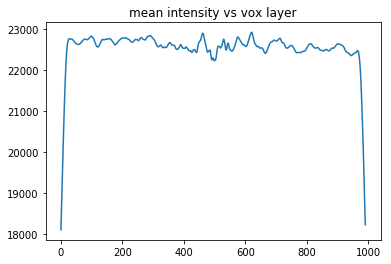

In [5]:
mean_z_intensity = np.mean(stack, axis = (0,1))

fig, ax = plt.subplots()
ax.set_title('mean intensity vs vox layer')
ax.plot(range(mean_z_intensity.shape[0]), mean_z_intensity)
plt.show()

In [31]:
bot_pad = widgets.IntText(
    value = 20,
    description='bot'
)

top_pad = widgets.IntText(
    value = 20,
    description='top'
)


ui = widgets.HBox([bot_pad, top_pad])

display(ui)


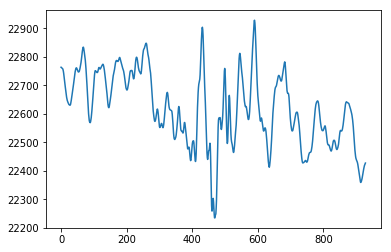

In [32]:
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

cpt = importr('changepoint')

cpm_result = cpt.multiple_mean_norm(FloatVector(mean_z_intensity),"BinSeg","MBIC",0,2,True,True,1)

change_pts = cpt.cpts(cpm_result)

bot = int(change_pts[0])+ bot_pad.value
top = int(change_pts[1])- top_pad.value
cut_warp = mean_z_intensity[bot:top]

fig, ax = plt.subplots()
ax.plot(range(cut_warp.shape[0]), cut_warp)
plt.show()

Text(0.5,1,'crop')

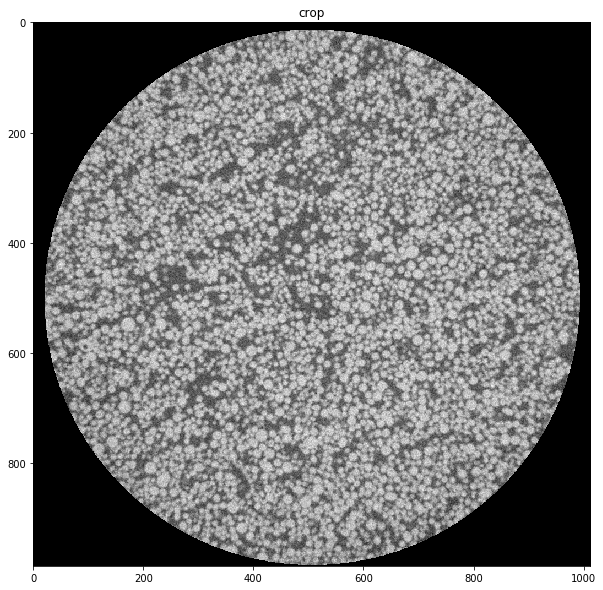

In [34]:
cropped = stack[:,:,bot:top]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cropped[:,:,100], cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('crop')

In [35]:

slice_num = widgets.IntSlider(
    value=7,
    min=0,
    max=cropped.shape[0],
    step=1
)

display(slice_num)

IntSlider(value=7, max=988)

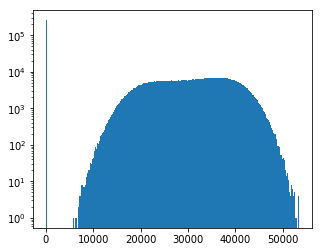

In [37]:
single_s = cropped[:,:,slice_num.value]
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.ravel(single_s), bins=256)
ax.set_yscale("log", nonposy='clip')


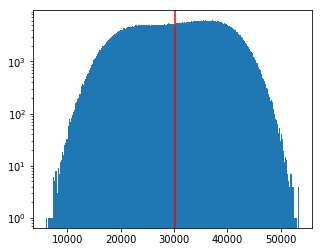

In [38]:
from skimage.filters import threshold_otsu
import numpy.ma as ma

masked = ma.masked_where(single_s == 0, single_s)

thresh = threshold_otsu(masked.compressed())

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.ravel(masked.compressed()), bins=256)
ax.axvline(thresh, color='r')
ax.set_yscale("log", nonposy='clip')


Text(0.5,1,'segmented')

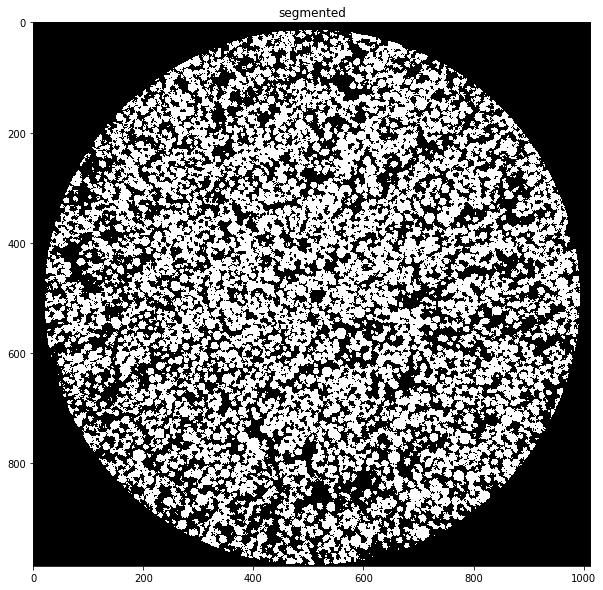

In [39]:
binary = single_s < thresh

new_im = np.copy(single_s)

new_im[binary] = 0
new_im[~binary] = 1

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_im, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmented')

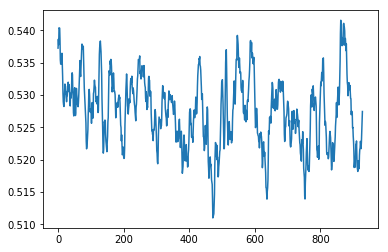

In [40]:
def density(im):
    height = im.shape[2]
    z_mean = np.zeros(height)
    for z in range(height): 
        sl = im[:,:,z]
        masked = ma.masked_where(sl == 0, sl)
        thresh = threshold_otsu(masked.compressed())

        binary = sl < thresh

        new_im = np.copy(sl)

        new_im[binary] = 0
        new_im[~binary] = 1

        n_masked = ma.masked_where(sl==0,new_im)
        z_mean[z] = np.mean(n_masked)
    return z_mean


z_mean = density(cropped)
fig, ax = plt.subplots()
ax.plot(range(cropped.shape[2]), z_mean)
plt.show()

In [41]:
import pandas as pd

df = pd.DataFrame(columns = ['fac_1','fac_2','fac_3','fac_4','z','density'])

for z in range(z_mean.shape[0]):
    df.loc[z] = [fac_1.value,fac_2.value,fac_3.value,fac_4.value,z,z_mean[z]]

In [42]:

save = widgets.Checkbox(
    value=False,
    description='save'
)

display(save)


Checkbox(value=False, description='save')

In [43]:
if(save.value):
    df.to_csv(output_path)

C:\Users\inst\.conda\envs\machine_learning\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


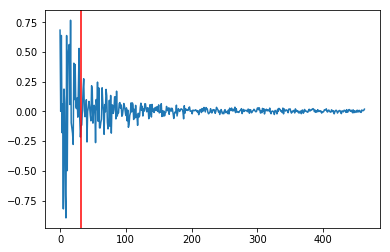

In [44]:
from numpy.fft import rfft

fourier_t = rfft(z_mean)

fig, ax = plt.subplots()
ax.plot(range(fourier_t.shape[0]-1),fourier_t[1:])
ax.axvline(32, color='r')
plt.show()

465


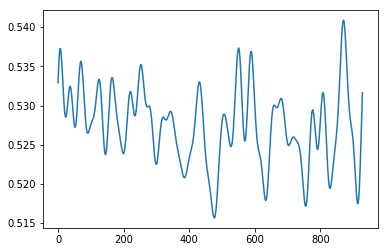

In [45]:
from numpy.fft import irfft
print(fourier_t.shape[0])

s = irfft(fourier_t[0:32],n=z_mean.shape[0])

fig, ax = plt.subplots()
ax.plot(range(s.shape[0]),s)
plt.show()